<a href="https://colab.research.google.com/github/carlos-gafa/PCA-Stock-Portfolio/blob/main/PCA_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import urllib3
from datetime import datetime
import pytz
import bs4 as bs
from sklearn.decomposition import PCA

# Get S&P500 Stock Data
Scrape ticker list from Wikipedia and remove tickers which were not included in the S&P500 before 2019, using the following helper function.

In [2]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    rows = table.find_all('tr')

    tickers = []

    for row in rows[1:]:
        cells = row.find_all('td')
        #if np.datetime64(cells[7].text.strip()[:4])<np.datetime64('2019'): #remove tickers which were not founded before 2019, however, some of these were not public beofre 2019 so no data exists
        if np.datetime64(cells[5].text.strip())<np.datetime64('2019-01-01'): #remove tickers which were not included in snp500 before 2019
            ticker = cells[0].text.strip()
            tickers.append(ticker)

    return tickers

tickers = get_sp500_tickers()
tickers = [tick.replace(".","-") for tick in tickers] #for stocks which have two share classes

print('Number of Stocks = ', len(tickers))
print()
print(tickers)

Number of Stocks =  402

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BF-B', 'BXP', 'CHRW', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'COR', 'CNC', 'CNP', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CPAY', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'DVN', 'FANG', 'DLR', 'DG', 'DLTR', 'D', 'DOV', 'DHI', 'DTE', 'DUK', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'E

Download close price of each ticker.

In [4]:
df = yf.download(tickers, start='2019-01-01', end='2021-12-01')['Close']

#check if there is missing data which needs to be addressed
print('Number of missing data points = ', np.sum(np.where(df.isna())[0]))

/tmp/ipython-input-4-1542833918.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start='2019-01-01', end='2021-12-01')['Close']
[*********************100%***********************]  402 of 402 completed


Number of missing data points =  0


# Normalize stock prices

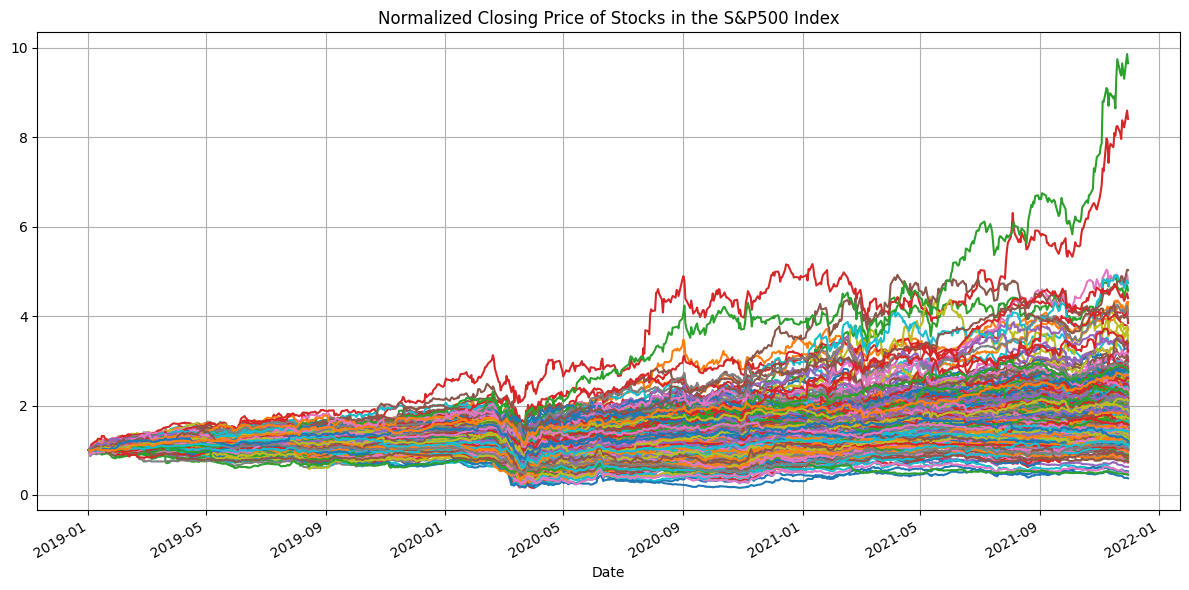

In [5]:
df=df/df.iloc[0]
df.plot(legend=0,figsize=(12,6), grid=True,title='Normalized Closing Price of Stocks in the S&P500 Index')
plt.tight_layout()

# Calculate Daily Log Returns

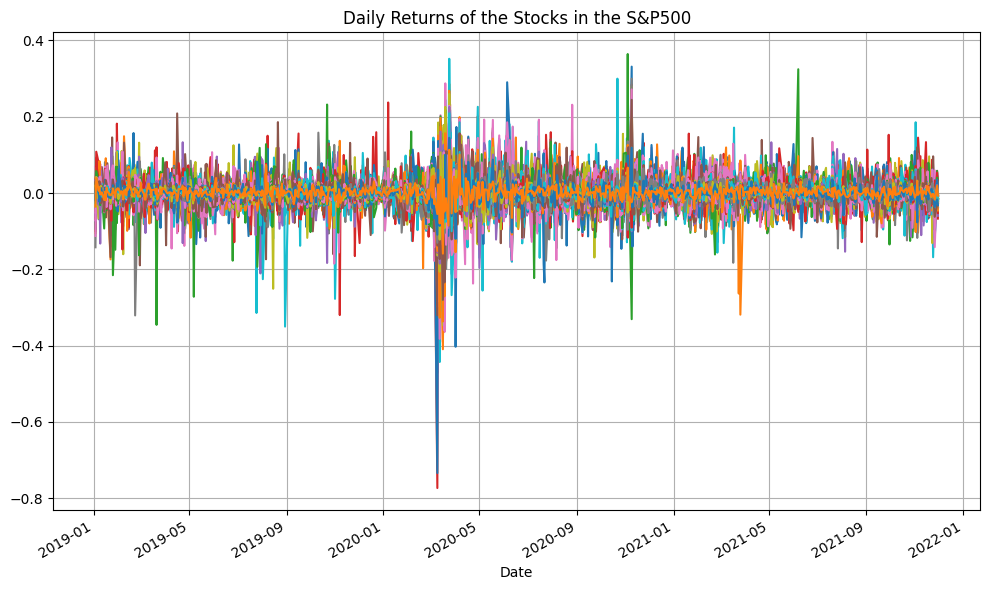

In [6]:
rs = df.apply(np.log).diff(1)
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()

# Principal Component Analysis
## PCA on Stock Returns

In [7]:
pca = PCA().fit(rs.fillna(0))

Explained variance ratio of each component

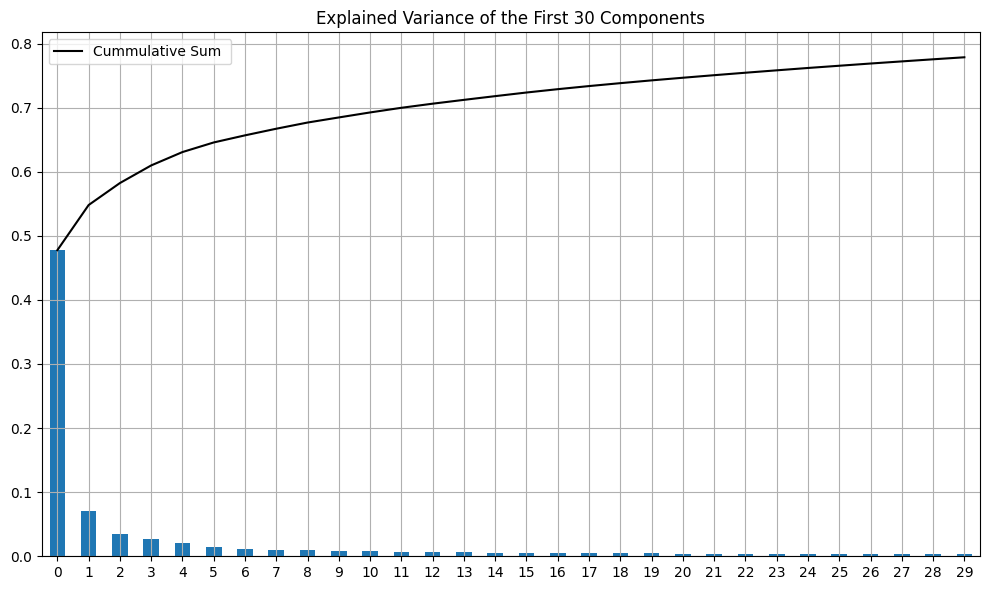

In [8]:
number_of_components=30
pd.Series(data=pca.explained_variance_ratio_[0:number_of_components]).plot.bar(figsize=(10,6), grid=True, title='Explained Variance of the First {i} Components'.format(i=number_of_components))
pd.Series(data=[np.sum(pca.explained_variance_ratio_[0:i]) for i in range(1,number_of_components+1)]).plot(figsize=(10,6), grid=True, label='Cummulative Sum ',color='black')
plt.legend()
plt.tight_layout()

## Weights of First PC

Number of stocks with a negative loading = 0


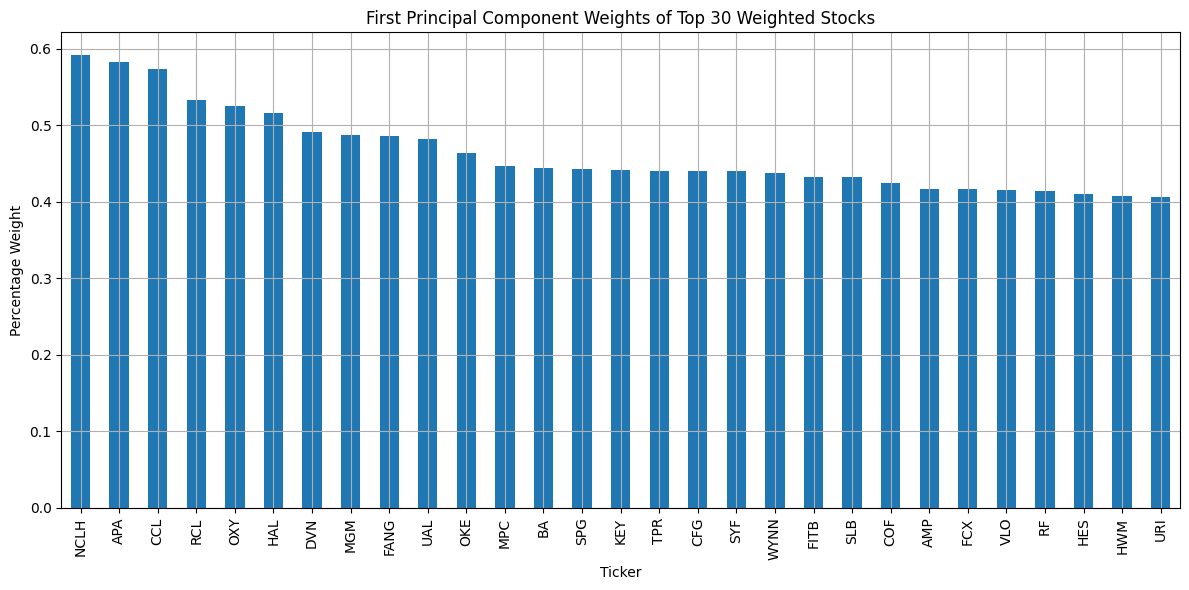

In [9]:
component_number=0
stock_weights_pca = (pca.components_[component_number])/(pca.components_[component_number]).sum()

all_same_direction = (np.array([np.sign(stock_weights_pca)== np.sign(stock_weights_pca[0])]))
print('Number of stocks with a negative loading =' , np.count_nonzero(all_same_direction[0]==False))

# define number of stocks to include
top_n = 30

bool_top_stocks = np.abs(stock_weights_pca) > np.sort(abs(stock_weights_pca))[len(stock_weights_pca)-top_n]

top_pca_weights = stock_weights_pca[bool_top_stocks]
top_pca_tickers = df.columns[bool_top_stocks]

top_pca_weighted_portfolio= pd.Series(index=top_pca_tickers,data=top_pca_weights)
top_pca_weighted_portfolio=top_pca_weighted_portfolio.iloc[np.flip(np.argsort(top_pca_weighted_portfolio.values))]
(100*top_pca_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='First Principal Component Weights of Top {i} Weighted Stocks'.format(i=top_n))
plt.tight_layout()

Compare PCA weighted protfolio with the market cap wieghted S&P500 index.

In [10]:
snp500 = yf.download('^GSPC', start='2019-01-01', end='2021-12-01')['Close']
rs_snp500 = snp500.apply(np.log).diff(1)

[*********************100%***********************]  1 of 1 completed


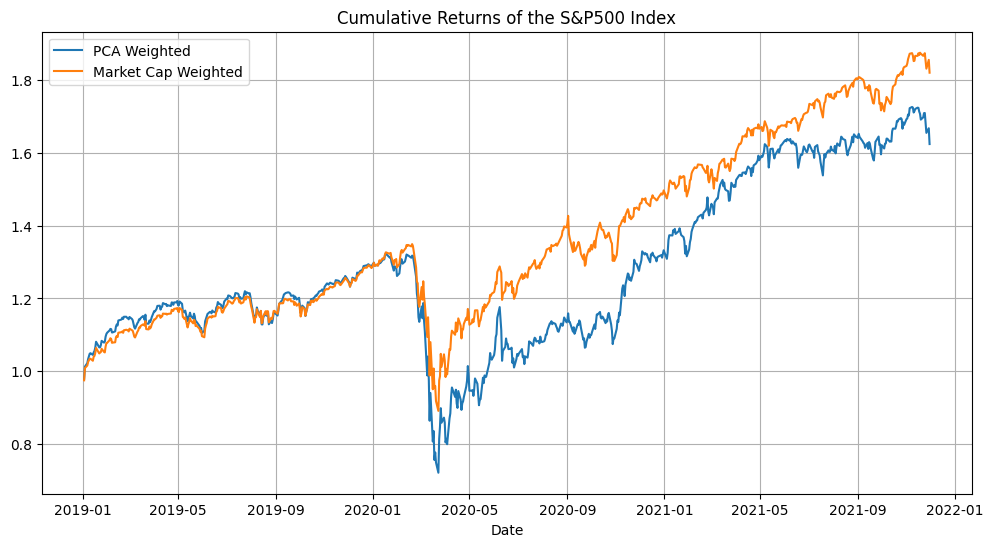

In [11]:
pca_weighted_portfolio_returns =rs.dot(np.abs(stock_weights_pca))

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pca_weighted_portfolio_returns).cumsum().apply(np.exp), label='PCA Weighted')
plt.plot((rs_snp500).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

## Restrict Date Range From March 2020 - Decemeber 2021

In [12]:
rs_covid=rs.loc['2020-03-01':'2021-12-31']
rs_snp500_covid = rs_snp500.loc['2020-03-01':'2021-12-31']

In [13]:
pca_covid = PCA().fit(rs_covid.fillna(0))

## First PC During COVID

Number of stocks with a negative loading = 0


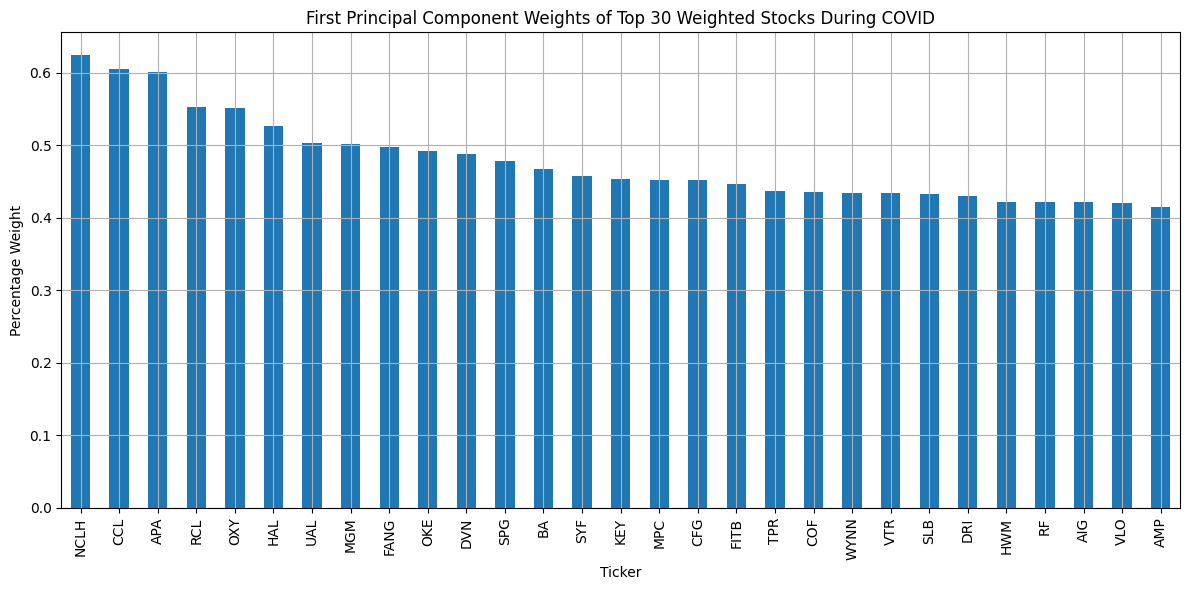

In [14]:
#Weight Stocks according to first principal component; normalize to sum up to 1
component_number=0
stock_weights_pca = (pca_covid.components_[component_number])/(pca_covid.components_[component_number]).sum()


all_same_direction = (np.array([np.sign(stock_weights_pca)== np.sign(stock_weights_pca[0])]))
print('Number of stocks with a negative loading =' , np.count_nonzero(all_same_direction[0]==False))

# define number of stocks to include
top_n = 30

bool_top_stocks = np.abs(stock_weights_pca) > np.sort(abs(stock_weights_pca))[len(stock_weights_pca)-top_n]

top_pca_weights = stock_weights_pca[bool_top_stocks]
top_pca_tickers = df.columns[bool_top_stocks]

top_pca_weighted_portfolio= pd.Series(index=top_pca_tickers,data=top_pca_weights)
top_pca_weighted_portfolio=top_pca_weighted_portfolio.iloc[np.flip(np.argsort(top_pca_weighted_portfolio.values))]
(100*top_pca_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='First Principal Component Weights of Top {i} Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

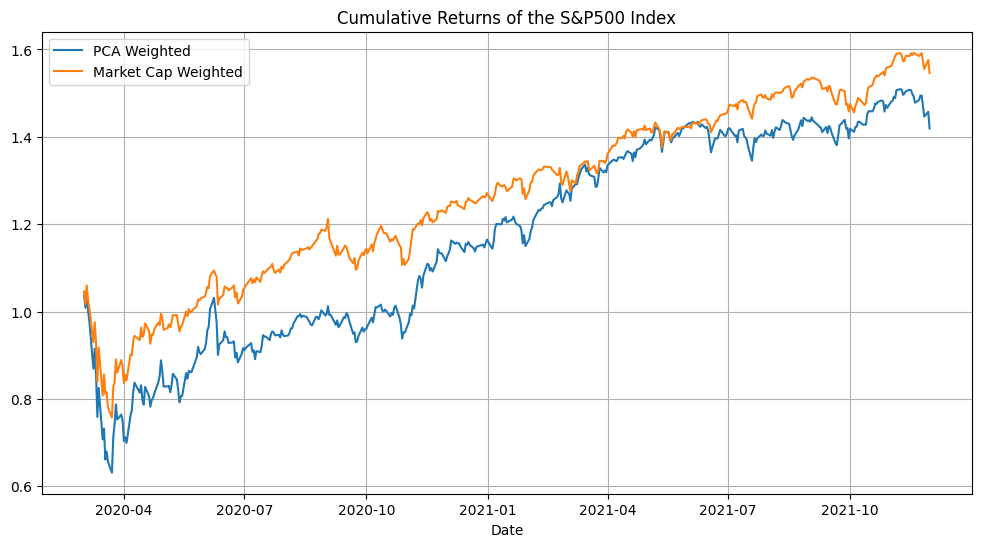

In [15]:
pca_weighted_portfolio_returns_covid =rs_covid.dot((stock_weights_pca))

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pca_weighted_portfolio_returns_covid).cumsum().apply(np.exp), label='PCA Weighted')
plt.plot((rs_snp500_covid).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

## Second PC During COVID